# REBER Grammar with RNN

In this workbook, we are going to set-up multiple Recurrent Neural Network to test them using as test <a href="https://www.willamette.edu/~gorr/classes/cs449/reber.html" target="_blank">Reber's grammar</a> words.

## What is a Reber Word ?

A Reber word is a word following the Reber's grammar. The grammar is based on the following graph:

<img src="reber.gif"/>

The word must start with B, then it can be either T or P and so on until it reaches E. To prepare data for this, we are going to use a OneHotEncoder to have 7 inputs, n timesteps (depending on the length of the word) and k batches. To generate it, I use the algorith from <a href="http://christianherta.de/lehre/dataScience/machineLearning/neuralNetworks/reberGrammar.php" target="_target">this site</a>

It also exists an Embedded version of the Reber Grammar using the following graph :

<img src="embreber.gif"/>

For now, we gonna focus on the simple version and based on the result, we may try the embedded version.

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns

import create_dataset as reber

from keras.datasets import imdb
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import LSTM, SimpleRNN, GRU
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.callbacks import ModelCheckpoint, EarlyStopping

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

%matplotlib inline

## Preparation of datas

For the OneHotEncoder, the chain 'BTSXPVE' will be used. We can now try only 1 example to check the output

In [18]:
x, y = reber.get_one_example(minLength=10)
print(reber.sequenceToWord(x))
print(x[0], y[0])

BTSXXTTVPXVV
[ 1.  0.  0.  0.  0.  0.  0.] [ 0.  1.  0.  0.  1.  0.  0.]


*y* is the possible outcome for a given input. That means B ([ 1.  0.  0.  0.  0.  0.  0.]) can be followed by T or P ([ 0.  1.  0.  0.  1.  0.  0.]).

However, we won't use y as output but for every timestep, we are going to provide the next timestep as target. For this, we will use the following function

In [19]:
def generate(x0):
    end = np.array([0.,  0.,  0.,  0.,  0.,  0.,  1.])
    y=x0[1:]
    y.append(end)
    return y

Now, if we take as input "BTSXS", the output will be "TSXSE" (but the input in encoded).

We can also generate few words to check the output.

In [20]:
min_length = 10
for i in range(10):
    inp, out = reber.get_one_example(min_length)
    print(reber.sequenceToWord(inp))

BTSSSXXTTTVV
BTXXTTTTVV
BTSSSXXTTTVV
BTXXVPXVPXTVV
BPTVPXVPXTVV
BTSXXVPXVV
BPTTTVPXTTTTVV
BPTTTTTTTVV
BTSSXXTTVV
BTXXTTVPXVV


So we have the first "problem" now, the length of the string is variable. So when we are going to generate our test/train datas, we will have to pad them to the same length (let's say 20). This is done by using <b>sequence.pad_sequences</b> for Keras Library

In [21]:
X_train, y_train = [], []
X_test, y_test = [], []
X_val, y_val = [], []
y_possible = []

for i in range(2048):
    x, y = reber.get_one_example(min_length)
    X_train.append(x)
    y_train.append(generate(x))

for i in range(256):
    x, y = reber.get_one_example(min_length)
    X_test.append(x)
    y_test.append(generate(x))  
    
for i in range(1):
    x, y = reber.get_one_example(min_length)
    X_val.append(x)
    y_val.append(generate(x))
    y_possible.append(y)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
X_val = np.array(X_val)
y_val = np.array(y_val)
y_possible = np.array(y_possible)

maxlen = 20
X_train = sequence.pad_sequences(X_train, maxlen=maxlen, padding='post', truncating='post')
y_train = sequence.pad_sequences(y_train, maxlen=maxlen, padding='post', truncating='post')
X_test = sequence.pad_sequences(X_test, maxlen=maxlen, padding='post', truncating='post')
y_test = sequence.pad_sequences(y_test, maxlen=maxlen, padding='post', truncating='post')
X_val = sequence.pad_sequences(X_val, maxlen=maxlen, padding='post', truncating='post')
y_val = sequence.pad_sequences(y_val, maxlen=maxlen, padding='post', truncating='post')
y_possible = sequence.pad_sequences(y_possible, maxlen=maxlen, padding='post', truncating='post')

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)
print(y_possible.shape)

(2048, 20, 7)
(2048, 20, 7)
(256, 20, 7)
(256, 20, 7)
(1, 20, 7)
(1, 20, 7)
(1, 20, 7)


In [22]:
print(y_possible)

[[[0 1 0 0 1 0 0]
  [0 0 1 1 0 0 0]
  [0 0 1 1 0 0 0]
  [0 0 1 1 0 0 0]
  [0 0 1 1 0 0 0]
  [0 1 0 0 0 1 0]
  [0 0 0 0 1 1 0]
  [0 0 1 1 0 0 0]
  [0 1 0 0 0 1 0]
  [0 1 0 0 0 1 0]
  [0 1 0 0 0 1 0]
  [0 0 0 0 1 1 0]
  [0 0 1 1 0 0 0]
  [0 1 0 0 0 1 0]
  [0 0 0 0 1 1 0]
  [0 0 0 0 0 0 1]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]]]


So now we have 2048 strings for training, 256 for test and 1 just for visualisation later. We can now set-up our model.

## Test of RNNs

For this model, we are going to use a many-to-many RNN. That means for every input, the model will predict an output. The training will be done based on the input we prepared previously. Once trained. We will be able to "transfer" the learning to a one-to-many model in order to have a "generator".

<img src="RNN_types.jpg"/>

During the writing of this notebook, I tried some loss, metrics and optimizer. The following ones are the one fitting the best

In [27]:
nb_unit = 7
inp_shape = (maxlen, 7)
loss_ = "mean_squared_error"
metrics_ = "mean_squared_error"
optimizer_ = "Nadam"
nb_epoch = 250
batch_size = 64

### LSTM

The first model we will setup is an <b>LSTM</b> which means <b>L</b>ong <b>S</b>hort-<b>T</b>erm <b>M</b>emory. The principle is 
quite complex but very powerfull for long sequences inputs (because there is less issues with Vanishing Gradient Problem) or long term memory (You can refer to <a href="http://colah.github.io/posts/2015-08-Understanding-LSTMs/" target="_blank">this link</a> for more informations)

LSTM is widely for speech recognition, Natural Language processing, Sentiment Analysis.

In [28]:
model = Sequential()

model.add(LSTM(units=nb_unit, input_shape=inp_shape, return_sequences=True))  # single LSTM
model.compile(loss=loss_,
              optimizer=optimizer_,
              metrics=[metrics_])

checkpoint = ModelCheckpoint("lstm_simple.h5",
    monitor=loss_,
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    period=1)
early = EarlyStopping(
    monitor='loss',
    min_delta=0,
    patience=10,
    verbose=1,
    mode='auto')

In [29]:
print("Inputs: {}".format(model.input_shape))
print("Outputs: {}".format(model.output_shape))
print("Actual input: {}".format(X_train.shape))
print("Actual output: {}".format(y_train.shape))

Inputs: (None, 20, 7)
Outputs: (None, 20, 7)
Actual input: (2048, 20, 7)
Actual output: (2048, 20, 7)


In [30]:
start = time.time()
history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=nb_epoch, 
                    batch_size=batch_size, 
                    verbose=2, 
                    callbacks = [checkpoint, early])
stop = time.time()
t1 = stop-start
print(model.summary())
print("Training time : {}s".format(t1))

Train on 2048 samples, validate on 256 samples
Epoch 1/250
Epoch 00001: mean_squared_error improved from inf to 0.08666, saving model to lstm_simple.h5
 - 1s - loss: 0.0867 - mean_squared_error: 0.0867 - val_loss: 0.0810 - val_mean_squared_error: 0.0810
Epoch 2/250
Epoch 00002: mean_squared_error improved from 0.08666 to 0.07840, saving model to lstm_simple.h5
 - 1s - loss: 0.0784 - mean_squared_error: 0.0784 - val_loss: 0.0751 - val_mean_squared_error: 0.0751
Epoch 3/250
Epoch 00003: mean_squared_error improved from 0.07840 to 0.07357, saving model to lstm_simple.h5
 - 1s - loss: 0.0736 - mean_squared_error: 0.0736 - val_loss: 0.0711 - val_mean_squared_error: 0.0711
Epoch 4/250
Epoch 00004: mean_squared_error improved from 0.07357 to 0.06978, saving model to lstm_simple.h5
 - 1s - loss: 0.0698 - mean_squared_error: 0.0698 - val_loss: 0.0676 - val_mean_squared_error: 0.0676
Epoch 5/250
Epoch 00005: mean_squared_error improved from 0.06978 to 0.06628, saving model to lstm_simple.h5
 - 1

Epoch 40/250
Epoch 00040: mean_squared_error improved from 0.03685 to 0.03678, saving model to lstm_simple.h5
 - 1s - loss: 0.0368 - mean_squared_error: 0.0368 - val_loss: 0.0361 - val_mean_squared_error: 0.0361
Epoch 41/250
Epoch 00041: mean_squared_error improved from 0.03678 to 0.03671, saving model to lstm_simple.h5
 - 1s - loss: 0.0367 - mean_squared_error: 0.0367 - val_loss: 0.0360 - val_mean_squared_error: 0.0360
Epoch 42/250
Epoch 00042: mean_squared_error improved from 0.03671 to 0.03666, saving model to lstm_simple.h5
 - 1s - loss: 0.0367 - mean_squared_error: 0.0367 - val_loss: 0.0360 - val_mean_squared_error: 0.0360
Epoch 43/250
Epoch 00043: mean_squared_error improved from 0.03666 to 0.03659, saving model to lstm_simple.h5
 - 1s - loss: 0.0366 - mean_squared_error: 0.0366 - val_loss: 0.0359 - val_mean_squared_error: 0.0359
Epoch 44/250
Epoch 00044: mean_squared_error improved from 0.03659 to 0.03653, saving model to lstm_simple.h5
 - 1s - loss: 0.0365 - mean_squared_error:

Epoch 79/250
Epoch 00079: mean_squared_error improved from 0.03537 to 0.03533, saving model to lstm_simple.h5
 - 1s - loss: 0.0353 - mean_squared_error: 0.0353 - val_loss: 0.0348 - val_mean_squared_error: 0.0348
Epoch 80/250
Epoch 00080: mean_squared_error improved from 0.03533 to 0.03531, saving model to lstm_simple.h5
 - 1s - loss: 0.0353 - mean_squared_error: 0.0353 - val_loss: 0.0347 - val_mean_squared_error: 0.0347
Epoch 81/250
Epoch 00081: mean_squared_error improved from 0.03531 to 0.03529, saving model to lstm_simple.h5
 - 1s - loss: 0.0353 - mean_squared_error: 0.0353 - val_loss: 0.0347 - val_mean_squared_error: 0.0347
Epoch 82/250
Epoch 00082: mean_squared_error improved from 0.03529 to 0.03526, saving model to lstm_simple.h5
 - 1s - loss: 0.0353 - mean_squared_error: 0.0353 - val_loss: 0.0347 - val_mean_squared_error: 0.0347
Epoch 83/250
Epoch 00083: mean_squared_error improved from 0.03526 to 0.03522, saving model to lstm_simple.h5
 - 1s - loss: 0.0352 - mean_squared_error:

Epoch 118/250
Epoch 00118: mean_squared_error improved from 0.03440 to 0.03439, saving model to lstm_simple.h5
 - 1s - loss: 0.0344 - mean_squared_error: 0.0344 - val_loss: 0.0339 - val_mean_squared_error: 0.0339
Epoch 119/250
Epoch 00119: mean_squared_error improved from 0.03439 to 0.03438, saving model to lstm_simple.h5
 - 1s - loss: 0.0344 - mean_squared_error: 0.0344 - val_loss: 0.0339 - val_mean_squared_error: 0.0339
Epoch 120/250
Epoch 00120: mean_squared_error improved from 0.03438 to 0.03437, saving model to lstm_simple.h5
 - 1s - loss: 0.0344 - mean_squared_error: 0.0344 - val_loss: 0.0339 - val_mean_squared_error: 0.0339
Epoch 121/250
Epoch 00121: mean_squared_error improved from 0.03437 to 0.03436, saving model to lstm_simple.h5
 - 1s - loss: 0.0344 - mean_squared_error: 0.0344 - val_loss: 0.0340 - val_mean_squared_error: 0.0340
Epoch 122/250
Epoch 00122: mean_squared_error improved from 0.03436 to 0.03435, saving model to lstm_simple.h5
 - 1s - loss: 0.0343 - mean_squared_e

Epoch 159/250
Epoch 00159: mean_squared_error improved from 0.03409 to 0.03408, saving model to lstm_simple.h5
 - 1s - loss: 0.0341 - mean_squared_error: 0.0341 - val_loss: 0.0337 - val_mean_squared_error: 0.0337
Epoch 160/250
Epoch 00160: mean_squared_error did not improve
 - 1s - loss: 0.0341 - mean_squared_error: 0.0341 - val_loss: 0.0337 - val_mean_squared_error: 0.0337
Epoch 161/250
Epoch 00161: mean_squared_error improved from 0.03408 to 0.03407, saving model to lstm_simple.h5
 - 1s - loss: 0.0341 - mean_squared_error: 0.0341 - val_loss: 0.0336 - val_mean_squared_error: 0.0336
Epoch 162/250
Epoch 00162: mean_squared_error improved from 0.03407 to 0.03405, saving model to lstm_simple.h5
 - 1s - loss: 0.0340 - mean_squared_error: 0.0340 - val_loss: 0.0337 - val_mean_squared_error: 0.0337
Epoch 163/250
Epoch 00163: mean_squared_error did not improve
 - 1s - loss: 0.0341 - mean_squared_error: 0.0341 - val_loss: 0.0337 - val_mean_squared_error: 0.0337
Epoch 164/250
Epoch 00164: mean_s

Epoch 202/250
Epoch 00202: mean_squared_error improved from 0.03388 to 0.03388, saving model to lstm_simple.h5
 - 1s - loss: 0.0339 - mean_squared_error: 0.0339 - val_loss: 0.0335 - val_mean_squared_error: 0.0335
Epoch 203/250
Epoch 00203: mean_squared_error did not improve
 - 1s - loss: 0.0339 - mean_squared_error: 0.0339 - val_loss: 0.0335 - val_mean_squared_error: 0.0335
Epoch 204/250
Epoch 00204: mean_squared_error improved from 0.03388 to 0.03388, saving model to lstm_simple.h5
 - 1s - loss: 0.0339 - mean_squared_error: 0.0339 - val_loss: 0.0335 - val_mean_squared_error: 0.0335
Epoch 205/250
Epoch 00205: mean_squared_error improved from 0.03388 to 0.03387, saving model to lstm_simple.h5
 - 1s - loss: 0.0339 - mean_squared_error: 0.0339 - val_loss: 0.0335 - val_mean_squared_error: 0.0335
Epoch 206/250
Epoch 00206: mean_squared_error improved from 0.03387 to 0.03386, saving model to lstm_simple.h5
 - 1s - loss: 0.0339 - mean_squared_error: 0.0339 - val_loss: 0.0335 - val_mean_square

Epoch 00245: mean_squared_error did not improve
 - 1s - loss: 0.0338 - mean_squared_error: 0.0338 - val_loss: 0.0334 - val_mean_squared_error: 0.0334
Epoch 246/250
Epoch 00246: mean_squared_error improved from 0.03375 to 0.03374, saving model to lstm_simple.h5
 - 1s - loss: 0.0337 - mean_squared_error: 0.0337 - val_loss: 0.0334 - val_mean_squared_error: 0.0334
Epoch 247/250
Epoch 00247: mean_squared_error did not improve
 - 1s - loss: 0.0337 - mean_squared_error: 0.0337 - val_loss: 0.0335 - val_mean_squared_error: 0.0335
Epoch 248/250
Epoch 00248: mean_squared_error did not improve
 - 1s - loss: 0.0337 - mean_squared_error: 0.0337 - val_loss: 0.0334 - val_mean_squared_error: 0.0334
Epoch 249/250
Epoch 00249: mean_squared_error improved from 0.03374 to 0.03374, saving model to lstm_simple.h5
 - 1s - loss: 0.0337 - mean_squared_error: 0.0337 - val_loss: 0.0334 - val_mean_squared_error: 0.0334
Epoch 250/250
Epoch 00250: mean_squared_error improved from 0.03374 to 0.03374, saving model to 

In [44]:
LSTM_steps = 250

## Simple RNN

Using the same code, we can train the standard RNN. The principle is that every output of every hidden layers, are also feed as entry for the next step

<img src="SimpleRNN.png"/>

This allows a "short term memory". It creates a kind of hysteresis used as memory

In [38]:
model2 = Sequential()
model2.add(SimpleRNN(units=nb_unit, input_shape=inp_shape, return_sequences=True))
model2.compile(loss=loss_,
              optimizer=optimizer_,
              metrics=[metrics_])

checkpoint = ModelCheckpoint("srnn_simple.h5",
    monitor=loss_,
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    period=1)
early = EarlyStopping(
    monitor='loss',
    min_delta=0,
    patience=10,
    verbose=1,
    mode='auto')

In [39]:
start = time.time()
history2 = model2.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=nb_epoch, 
                    batch_size=batch_size, 
                    verbose=2, 
                    callbacks = [checkpoint, early])
stop = time.time()
t2 = stop-start
print(model2.summary(), end=" ")
print("Training time : {}s".format(t2))

Train on 2048 samples, validate on 256 samples
Epoch 1/250
Epoch 00001: mean_squared_error improved from inf to 0.20902, saving model to srnn_simple.h5
 - 1s - loss: 0.2090 - mean_squared_error: 0.2090 - val_loss: 0.1713 - val_mean_squared_error: 0.1713
Epoch 2/250
Epoch 00002: mean_squared_error improved from 0.20902 to 0.14580, saving model to srnn_simple.h5
 - 0s - loss: 0.1458 - mean_squared_error: 0.1458 - val_loss: 0.1254 - val_mean_squared_error: 0.1254
Epoch 3/250
Epoch 00003: mean_squared_error improved from 0.14580 to 0.11278, saving model to srnn_simple.h5
 - 0s - loss: 0.1128 - mean_squared_error: 0.1128 - val_loss: 0.1021 - val_mean_squared_error: 0.1021
Epoch 4/250
Epoch 00004: mean_squared_error improved from 0.11278 to 0.09488, saving model to srnn_simple.h5
 - 0s - loss: 0.0949 - mean_squared_error: 0.0949 - val_loss: 0.0883 - val_mean_squared_error: 0.0883
Epoch 5/250
Epoch 00005: mean_squared_error improved from 0.09488 to 0.08371, saving model to srnn_simple.h5
 - 0

Epoch 40/250
Epoch 00040: mean_squared_error improved from 0.04784 to 0.04771, saving model to srnn_simple.h5
 - 0s - loss: 0.0477 - mean_squared_error: 0.0477 - val_loss: 0.0474 - val_mean_squared_error: 0.0474
Epoch 41/250
Epoch 00041: mean_squared_error improved from 0.04771 to 0.04758, saving model to srnn_simple.h5
 - 0s - loss: 0.0476 - mean_squared_error: 0.0476 - val_loss: 0.0473 - val_mean_squared_error: 0.0473
Epoch 42/250
Epoch 00042: mean_squared_error improved from 0.04758 to 0.04746, saving model to srnn_simple.h5
 - 0s - loss: 0.0475 - mean_squared_error: 0.0475 - val_loss: 0.0472 - val_mean_squared_error: 0.0472
Epoch 43/250
Epoch 00043: mean_squared_error improved from 0.04746 to 0.04734, saving model to srnn_simple.h5
 - 0s - loss: 0.0473 - mean_squared_error: 0.0473 - val_loss: 0.0471 - val_mean_squared_error: 0.0471
Epoch 44/250
Epoch 00044: mean_squared_error improved from 0.04734 to 0.04723, saving model to srnn_simple.h5
 - 0s - loss: 0.0472 - mean_squared_error:

Epoch 80/250
Epoch 00080: mean_squared_error improved from 0.04549 to 0.04548, saving model to srnn_simple.h5
 - 0s - loss: 0.0455 - mean_squared_error: 0.0455 - val_loss: 0.0453 - val_mean_squared_error: 0.0453
Epoch 81/250
Epoch 00081: mean_squared_error improved from 0.04548 to 0.04548, saving model to srnn_simple.h5
 - 0s - loss: 0.0455 - mean_squared_error: 0.0455 - val_loss: 0.0453 - val_mean_squared_error: 0.0453
Epoch 82/250
Epoch 00082: mean_squared_error improved from 0.04548 to 0.04546, saving model to srnn_simple.h5
 - 0s - loss: 0.0455 - mean_squared_error: 0.0455 - val_loss: 0.0453 - val_mean_squared_error: 0.0453
Epoch 83/250
Epoch 00083: mean_squared_error improved from 0.04546 to 0.04544, saving model to srnn_simple.h5
 - 0s - loss: 0.0454 - mean_squared_error: 0.0454 - val_loss: 0.0452 - val_mean_squared_error: 0.0452
Epoch 84/250
Epoch 00084: mean_squared_error improved from 0.04544 to 0.04543, saving model to srnn_simple.h5
 - 0s - loss: 0.0454 - mean_squared_error:

Epoch 122/250
Epoch 00122: mean_squared_error improved from 0.04520 to 0.04520, saving model to srnn_simple.h5
 - 0s - loss: 0.0452 - mean_squared_error: 0.0452 - val_loss: 0.0450 - val_mean_squared_error: 0.0450
Epoch 123/250
Epoch 00123: mean_squared_error improved from 0.04520 to 0.04520, saving model to srnn_simple.h5
 - 0s - loss: 0.0452 - mean_squared_error: 0.0452 - val_loss: 0.0449 - val_mean_squared_error: 0.0449
Epoch 124/250
Epoch 00124: mean_squared_error improved from 0.04520 to 0.04519, saving model to srnn_simple.h5
 - 0s - loss: 0.0452 - mean_squared_error: 0.0452 - val_loss: 0.0450 - val_mean_squared_error: 0.0450
Epoch 125/250
Epoch 00125: mean_squared_error improved from 0.04519 to 0.04519, saving model to srnn_simple.h5
 - 0s - loss: 0.0452 - mean_squared_error: 0.0452 - val_loss: 0.0450 - val_mean_squared_error: 0.0450
Epoch 126/250
Epoch 00126: mean_squared_error did not improve
 - 0s - loss: 0.0452 - mean_squared_error: 0.0452 - val_loss: 0.0450 - val_mean_square

Epoch 167/250
Epoch 00167: mean_squared_error did not improve
 - 0s - loss: 0.0451 - mean_squared_error: 0.0451 - val_loss: 0.0449 - val_mean_squared_error: 0.0449
Epoch 168/250
Epoch 00168: mean_squared_error did not improve
 - 0s - loss: 0.0451 - mean_squared_error: 0.0451 - val_loss: 0.0449 - val_mean_squared_error: 0.0449
Epoch 169/250
Epoch 00169: mean_squared_error improved from 0.04512 to 0.04511, saving model to srnn_simple.h5
 - 0s - loss: 0.0451 - mean_squared_error: 0.0451 - val_loss: 0.0449 - val_mean_squared_error: 0.0449
Epoch 170/250
Epoch 00170: mean_squared_error did not improve
 - 0s - loss: 0.0451 - mean_squared_error: 0.0451 - val_loss: 0.0449 - val_mean_squared_error: 0.0449
Epoch 171/250
Epoch 00171: mean_squared_error did not improve
 - 0s - loss: 0.0451 - mean_squared_error: 0.0451 - val_loss: 0.0449 - val_mean_squared_error: 0.0449
Epoch 172/250
Epoch 00172: mean_squared_error did not improve
 - 0s - loss: 0.0451 - mean_squared_error: 0.0451 - val_loss: 0.0449 

In [51]:
SRNN_steps = 198

## GRU

Finally, we can train a <b>GRU</b> (<b>G</b>ated <b>R</b>ecurrent <b>U</b>nits). It's a simplification of LSTMs. They also have a memory mechanism but with less parameters. As a result they are faster to train. You can find differences on <a href="https://datascience.stackexchange.com/questions/14581/what-is-difference-between-gru-and-lstm" target="_blank">this topic</a> 

In [40]:
model3 = Sequential()
model3.add(GRU(units=nb_unit, input_shape=inp_shape, return_sequences=True))
model3.compile(loss=loss_,
              optimizer=optimizer_,
              metrics=[metrics_])

checkpoint = ModelCheckpoint("gru_simple.h5",
    monitor=loss_,
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    period=1)
early = EarlyStopping(
    monitor='loss',
    min_delta=0,
    patience=10,
    verbose=1,
    mode='auto')

In [41]:
start = time.time()
history3 = model3.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=nb_epoch, 
                    batch_size=batch_size, 
                    verbose=2, 
                    callbacks = [checkpoint, early])
stop = time.time()
t3 = stop-start
print(model3.summary(), end=" ")
print("Training time : {}s".format(t3))

Train on 2048 samples, validate on 256 samples
Epoch 1/250
Epoch 00001: mean_squared_error improved from inf to 0.08024, saving model to gru_simple.h5
 - 1s - loss: 0.0802 - mean_squared_error: 0.0802 - val_loss: 0.0734 - val_mean_squared_error: 0.0734
Epoch 2/250
Epoch 00002: mean_squared_error improved from 0.08024 to 0.07086, saving model to gru_simple.h5
 - 1s - loss: 0.0709 - mean_squared_error: 0.0709 - val_loss: 0.0678 - val_mean_squared_error: 0.0678
Epoch 3/250
Epoch 00003: mean_squared_error improved from 0.07086 to 0.06643, saving model to gru_simple.h5
 - 1s - loss: 0.0664 - mean_squared_error: 0.0664 - val_loss: 0.0642 - val_mean_squared_error: 0.0642
Epoch 4/250
Epoch 00004: mean_squared_error improved from 0.06643 to 0.06312, saving model to gru_simple.h5
 - 1s - loss: 0.0631 - mean_squared_error: 0.0631 - val_loss: 0.0612 - val_mean_squared_error: 0.0612
Epoch 5/250
Epoch 00005: mean_squared_error improved from 0.06312 to 0.06025, saving model to gru_simple.h5
 - 1s - l

Epoch 40/250
Epoch 00040: mean_squared_error improved from 0.03670 to 0.03664, saving model to gru_simple.h5
 - 1s - loss: 0.0366 - mean_squared_error: 0.0366 - val_loss: 0.0362 - val_mean_squared_error: 0.0362
Epoch 41/250
Epoch 00041: mean_squared_error improved from 0.03664 to 0.03658, saving model to gru_simple.h5
 - 1s - loss: 0.0366 - mean_squared_error: 0.0366 - val_loss: 0.0361 - val_mean_squared_error: 0.0361
Epoch 42/250
Epoch 00042: mean_squared_error improved from 0.03658 to 0.03655, saving model to gru_simple.h5
 - 1s - loss: 0.0365 - mean_squared_error: 0.0365 - val_loss: 0.0361 - val_mean_squared_error: 0.0361
Epoch 43/250
Epoch 00043: mean_squared_error improved from 0.03655 to 0.03649, saving model to gru_simple.h5
 - 1s - loss: 0.0365 - mean_squared_error: 0.0365 - val_loss: 0.0360 - val_mean_squared_error: 0.0360
Epoch 44/250
Epoch 00044: mean_squared_error improved from 0.03649 to 0.03643, saving model to gru_simple.h5
 - 1s - loss: 0.0364 - mean_squared_error: 0.03

Epoch 00079: mean_squared_error improved from 0.03559 to 0.03553, saving model to gru_simple.h5
 - 1s - loss: 0.0355 - mean_squared_error: 0.0355 - val_loss: 0.0351 - val_mean_squared_error: 0.0351
Epoch 80/250
Epoch 00080: mean_squared_error improved from 0.03553 to 0.03553, saving model to gru_simple.h5
 - 1s - loss: 0.0355 - mean_squared_error: 0.0355 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 81/250
Epoch 00081: mean_squared_error improved from 0.03553 to 0.03551, saving model to gru_simple.h5
 - 1s - loss: 0.0355 - mean_squared_error: 0.0355 - val_loss: 0.0352 - val_mean_squared_error: 0.0352
Epoch 82/250
Epoch 00082: mean_squared_error improved from 0.03551 to 0.03548, saving model to gru_simple.h5
 - 1s - loss: 0.0355 - mean_squared_error: 0.0355 - val_loss: 0.0351 - val_mean_squared_error: 0.0351
Epoch 83/250
Epoch 00083: mean_squared_error improved from 0.03548 to 0.03548, saving model to gru_simple.h5
 - 1s - loss: 0.0355 - mean_squared_error: 0.0355 - val_loss

Epoch 118/250
Epoch 00118: mean_squared_error improved from 0.03496 to 0.03496, saving model to gru_simple.h5
 - 1s - loss: 0.0350 - mean_squared_error: 0.0350 - val_loss: 0.0345 - val_mean_squared_error: 0.0345
Epoch 119/250
Epoch 00119: mean_squared_error improved from 0.03496 to 0.03496, saving model to gru_simple.h5
 - 1s - loss: 0.0350 - mean_squared_error: 0.0350 - val_loss: 0.0345 - val_mean_squared_error: 0.0345
Epoch 120/250
Epoch 00120: mean_squared_error improved from 0.03496 to 0.03494, saving model to gru_simple.h5
 - 1s - loss: 0.0349 - mean_squared_error: 0.0349 - val_loss: 0.0345 - val_mean_squared_error: 0.0345
Epoch 121/250
Epoch 00121: mean_squared_error improved from 0.03494 to 0.03493, saving model to gru_simple.h5
 - 1s - loss: 0.0349 - mean_squared_error: 0.0349 - val_loss: 0.0344 - val_mean_squared_error: 0.0344
Epoch 122/250
Epoch 00122: mean_squared_error improved from 0.03493 to 0.03492, saving model to gru_simple.h5
 - 1s - loss: 0.0349 - mean_squared_error:

Epoch 160/250
Epoch 00160: mean_squared_error did not improve
 - 1s - loss: 0.0346 - mean_squared_error: 0.0346 - val_loss: 0.0342 - val_mean_squared_error: 0.0342
Epoch 161/250
Epoch 00161: mean_squared_error improved from 0.03461 to 0.03460, saving model to gru_simple.h5
 - 1s - loss: 0.0346 - mean_squared_error: 0.0346 - val_loss: 0.0341 - val_mean_squared_error: 0.0341
Epoch 162/250
Epoch 00162: mean_squared_error did not improve
 - 1s - loss: 0.0346 - mean_squared_error: 0.0346 - val_loss: 0.0341 - val_mean_squared_error: 0.0341
Epoch 163/250
Epoch 00163: mean_squared_error improved from 0.03460 to 0.03460, saving model to gru_simple.h5
 - 1s - loss: 0.0346 - mean_squared_error: 0.0346 - val_loss: 0.0342 - val_mean_squared_error: 0.0342
Epoch 164/250
Epoch 00164: mean_squared_error improved from 0.03460 to 0.03459, saving model to gru_simple.h5
 - 1s - loss: 0.0346 - mean_squared_error: 0.0346 - val_loss: 0.0342 - val_mean_squared_error: 0.0342
Epoch 165/250
Epoch 00165: mean_squa

Epoch 203/250
Epoch 00203: mean_squared_error improved from 0.03443 to 0.03442, saving model to gru_simple.h5
 - 1s - loss: 0.0344 - mean_squared_error: 0.0344 - val_loss: 0.0340 - val_mean_squared_error: 0.0340
Epoch 204/250
Epoch 00204: mean_squared_error improved from 0.03442 to 0.03441, saving model to gru_simple.h5
 - 1s - loss: 0.0344 - mean_squared_error: 0.0344 - val_loss: 0.0339 - val_mean_squared_error: 0.0339
Epoch 205/250
Epoch 00205: mean_squared_error did not improve
 - 1s - loss: 0.0344 - mean_squared_error: 0.0344 - val_loss: 0.0340 - val_mean_squared_error: 0.0340
Epoch 206/250
Epoch 00206: mean_squared_error improved from 0.03441 to 0.03441, saving model to gru_simple.h5
 - 1s - loss: 0.0344 - mean_squared_error: 0.0344 - val_loss: 0.0340 - val_mean_squared_error: 0.0340
Epoch 207/250
Epoch 00207: mean_squared_error did not improve
 - 1s - loss: 0.0344 - mean_squared_error: 0.0344 - val_loss: 0.0340 - val_mean_squared_error: 0.0340
Epoch 208/250
Epoch 00208: mean_squa

Epoch 248/250
Epoch 00248: mean_squared_error did not improve
 - 1s - loss: 0.0343 - mean_squared_error: 0.0343 - val_loss: 0.0339 - val_mean_squared_error: 0.0339
Epoch 249/250
Epoch 00249: mean_squared_error did not improve
 - 1s - loss: 0.0343 - mean_squared_error: 0.0343 - val_loss: 0.0339 - val_mean_squared_error: 0.0339
Epoch 250/250
Epoch 00250: mean_squared_error did not improve
 - 1s - loss: 0.0343 - mean_squared_error: 0.0343 - val_loss: 0.0338 - val_mean_squared_error: 0.0338
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 20, 7)             315       
Total params: 315
Trainable params: 315
Non-trainable params: 0
_________________________________________________________________
None Training time : 152.4062421321869s


In [47]:
GRU_steps = 250

## Evaluation

We can first check the time used to train them on the same dataset with the same number of epochs.

In [48]:
print("LSTM :       {:.2f}s".format(t1))
print("Simple RNN : {:.2f}s".format(t2))
print("GRU :        {:.2f}s".format(t3))

LSTM :       185.01s
Simple RNN : 53.97s
GRU :        152.41s


We can see that the simple RNN is the fastest to train because there is nearly no impact of provide the output as input. It's only and addtion to do on Matrices. However, LSTM and GRU are slower to train and as expected, GRU trained faster than LSTM. Ze can also check the error of prediction. For this I used a Mean Absolute Error as loss fonction and Mean Squared Error as metrics . I used this loss fonction to have the norm 1 between prediction and real output. With the Means Squared Error, the training would take longer as the loss would be smaller as all outputs are below 1. For the metric, I used it to ease the visualisation.

In [54]:
print([LSTM_steps, SRNN_steps, GRU_steps])

[250, 198, 250]


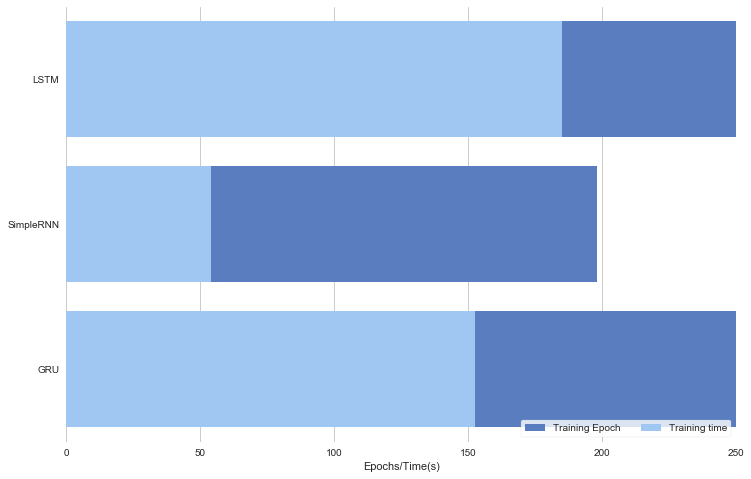

In [60]:
sns.set(style="whitegrid")

f, ax = plt.subplots(figsize=(12, 8))

sns.set_color_codes("muted")
sns.barplot(x=[LSTM_steps, SRNN_steps, GRU_steps], y=["LSTM", "SimpleRNN", "GRU"], label="Training Epoch", color="b")

sns.set_color_codes("pastel")
sns.barplot(x=[t1, t2, t3] , y=["LSTM", "SimpleRNN", "GRU"], label="Training time", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 250), ylabel="",
       xlabel="Epochs/Time(s)")
sns.despine(left=True, bottom=True)
plt.savefig("barplot.png")
plt.show()

dict_keys(['val_loss', 'val_mean_squared_error', 'loss', 'mean_squared_error'])


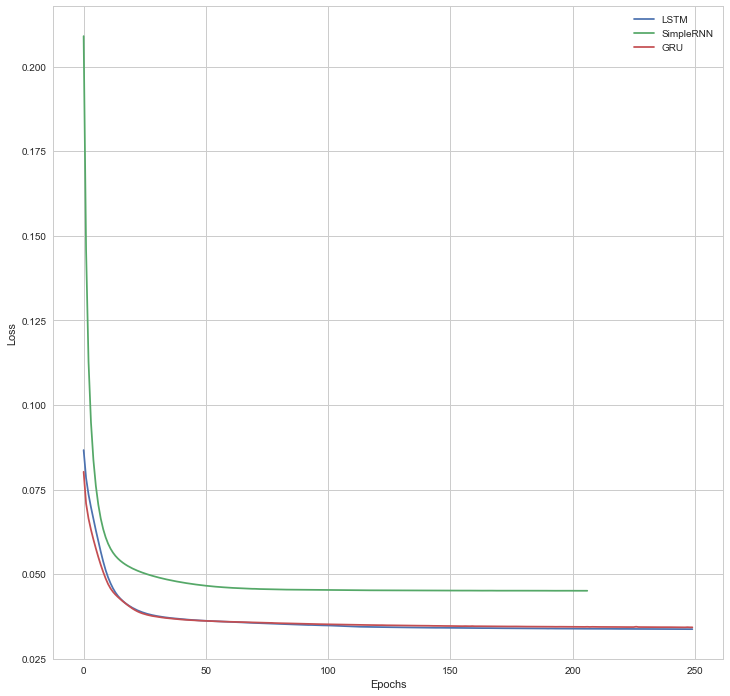

In [98]:
print(history.history.keys())
key_ = list(history.history.keys())[3]
plt.figure(figsize=(12, 12))
plt.plot(history.history[key_], label="LSTM")
plt.plot(history2.history[key_], label="SimpleRNN")
plt.plot(history3.history[key_], label="GRU")
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.savefig("loss.png")
plt.show()

We can see that GRU and LSTM perform better than a Simple RNN. LSTM is also performing slightly better that GRU but require more computation time. We can also check the output and compare it to the real output provided by the graph (see the y description in preparation of data section)

In [17]:
print("Input :")
print(X_val)
print("\n\nLSTM predicts :")
y_pred = model.predict(X_val)
print(y_pred)
print("\n\nGRU predicts :")
y_pred = model3.predict(X_val)
print(y_pred)

Input :
[[[1 0 0 0 0 0 0]
  [0 0 0 0 1 0 0]
  [0 1 0 0 0 0 0]
  [0 1 0 0 0 0 0]
  [0 0 0 0 0 1 0]
  [0 0 0 0 1 0 0]
  [0 0 0 1 0 0 0]
  [0 0 0 0 0 1 0]
  [0 0 0 0 1 0 0]
  [0 0 1 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]]]


LSTM predicts :
[[[ 0.02   0.556  0.009 -0.018  0.444 -0.007 -0.007]
  [ 0.048  0.702  0.006  0.099 -0.013  0.113  0.   ]
  [ 0.007  0.711  0.033  0.073  0.003  0.228 -0.   ]
  [-0.001  0.694  0.007  0.07   0.021  0.274 -0.   ]
  [ 0.005  0.038  0.001  0.     0.726  0.079  0.022]
  [-0.04   0.034  0.202  0.821 -0.016  0.042  0.032]
  [-0.     0.625 -0.009  0.006 -0.003  0.423  0.014]
  [-0.003 -0.012 -0.002 -0.     0.702  0.284  0.077]
  [-0.053 -0.002  0.254  0.653 -0.028  0.063  0.027]
  [ 0.029  0.026  0.043  0.009  0.002  0.026  0.894]
  [ 0.011  0.007 -0.001 -0.008  0.     0.011 -0.003]
  [ 0.007 -0.001  0.001 -0.00

We can simply the output by removing small output and compare it to the possible output (we will only keep prediction from GRU)

In [18]:
y_pred = np.where(y_pred < 0.1, 0, y_pred)

In [19]:
for pred, real in zip(y_pred[0], y_possible[0]):
    print(pred, "\t", real)

[ 0.     0.586  0.     0.     0.414  0.     0.   ] 	 [0 1 0 0 1 0 0]
[ 0.     0.672  0.138  0.127  0.     0.277  0.   ] 	 [0 1 0 0 0 1 0]
[ 0.     0.623  0.     0.     0.     0.31   0.   ] 	 [0 1 0 0 0 1 0]
[ 0.     0.602  0.1    0.     0.     0.338  0.   ] 	 [0 1 0 0 0 1 0]
[ 0.     0.     0.     0.     0.779  0.232  0.   ] 	 [0 0 0 0 1 1 0]
[ 0.     0.     0.164  0.782  0.     0.     0.   ] 	 [0 0 1 1 0 0 0]
[ 0.     0.571  0.     0.     0.     0.375  0.   ] 	 [0 1 0 0 0 1 0]
[ 0.     0.     0.     0.     0.725  0.291  0.   ] 	 [0 0 0 0 1 1 0]
[ 0.     0.     0.153  0.704  0.     0.     0.   ] 	 [0 0 1 1 0 0 0]
[ 0.     0.103  0.     0.     0.     0.     0.869] 	 [0 0 0 0 0 0 1]
[ 0.  0.  0.  0.  0.  0.  0.] 	 [0 0 0 0 0 0 0]
[ 0.  0.  0.  0.  0.  0.  0.] 	 [0 0 0 0 0 0 0]
[ 0.  0.  0.  0.  0.  0.  0.] 	 [0 0 0 0 0 0 0]
[ 0.  0.  0.  0.  0.  0.  0.] 	 [0 0 0 0 0 0 0]
[ 0.  0.  0.  0.  0.  0.  0.] 	 [0 0 0 0 0 0 0]
[ 0.  0.  0.  0.  0.  0.  0.] 	 [0 0 0 0 0 0 0]
[ 0.  0.  0.  0.  0.  

Yeah !! Output is balanced between both offset but with different "probabilities". We can also check how well they are to generate sentences

## Use it as generator

As explained previously, we trained our model as a many-to-many RNN. Now we want a generator so we are going to use a one-to-many model but reusing knowledge from the training. 

Before that, we will need an evaluation function which take the output, pick the next input based on the probability to have this output, create the next input and run it until the graph is over. After that, we will check is the created word is really a Reber word. This will be done with following functions 

In [66]:
def Pick_From_Output(x):
    y = np.zeros_like(x)
    x = np.where(x < 0.1, 0, x)
    x = x[0]/x[0].sum(axis=1)
    i = np.random.choice(list(range(7)), size=1, p=x[0])
    y[0,0,i] = 1
    return y

def evaluate(model, nb_word = 1, max_iter = 50):
    good_pred = 0
    for _ in range(nb_word):
        model.reset_states()
        first_input = np.array([[[1,0,0,0,0,0,0]]])
        word = "B"
        loop = 0
        nextLetter = "B"
        next_seq = first_input
        while nextLetter != "E" and loop < max_iter:
            y_pred = model.predict(next_seq)
            next_seq = Pick_From_Output(y_pred)
            nextLetter = reber.sequenceToWord(next_seq[0])
            loop += 1
            word += nextLetter
        if reber.in_grammar(word):
            good_pred += 1
    acc = 100*good_pred/nb_word
    print("Good prediction : {:.2f}%".format(acc))
    return acc

In [67]:
nb_samples = 20

Now let's create both model as one-to-many and evaluate them 20 times on 100 words generated.

In [70]:
Model = load_model("lstm_simple.h5")  # lstm_simple /  srnn_simple / gru_simple

newModel = Sequential()
newModel.add(LSTM(units=7, stateful=True, batch_input_shape=(1,1,7), return_sequences=True))
newModel.set_weights(Model.get_weights())

In [71]:
result_LSTM = []
for _ in range(nb_samples):
    result_LSTM.append(evaluate(newModel, 100, 50))

Good prediction : 90.00%
Good prediction : 92.00%
Good prediction : 94.00%
Good prediction : 95.00%
Good prediction : 96.00%
Good prediction : 94.00%
Good prediction : 95.00%
Good prediction : 94.00%
Good prediction : 93.00%
Good prediction : 98.00%
Good prediction : 93.00%
Good prediction : 95.00%
Good prediction : 92.00%
Good prediction : 93.00%
Good prediction : 99.00%
Good prediction : 94.00%
Good prediction : 97.00%
Good prediction : 95.00%
Good prediction : 96.00%
Good prediction : 93.00%


In [76]:
Model = load_model("srnn_simple.h5")

newModel = Sequential()
newModel.add(SimpleRNN(units=7, stateful=True, batch_input_shape=(1,1,7), return_sequences=True))
newModel.set_weights(Model.get_weights())

In [77]:
result_SRNN = []
for _ in range(nb_samples):
    result_SRNN.append(evaluate(newModel, 100, 50))

Good prediction : 11.00%
Good prediction : 8.00%
Good prediction : 8.00%
Good prediction : 12.00%
Good prediction : 10.00%
Good prediction : 9.00%
Good prediction : 10.00%
Good prediction : 13.00%
Good prediction : 6.00%
Good prediction : 7.00%
Good prediction : 12.00%
Good prediction : 14.00%
Good prediction : 8.00%
Good prediction : 14.00%
Good prediction : 6.00%
Good prediction : 16.00%
Good prediction : 8.00%
Good prediction : 7.00%
Good prediction : 12.00%
Good prediction : 11.00%


In [73]:
Model = load_model("gru_simple.h5")

newModel = Sequential()
newModel.add(GRU(units=7, stateful=True, batch_input_shape=(1,1,7), return_sequences=True))
newModel.set_weights(Model.get_weights())

In [74]:
result_GRU = []
for _ in range(nb_samples):
    result_GRU.append(evaluate(newModel, 100, 50))

Good prediction : 89.00%
Good prediction : 87.00%
Good prediction : 81.00%
Good prediction : 84.00%
Good prediction : 82.00%
Good prediction : 84.00%
Good prediction : 88.00%
Good prediction : 86.00%
Good prediction : 83.00%
Good prediction : 87.00%
Good prediction : 76.00%
Good prediction : 87.00%
Good prediction : 88.00%
Good prediction : 77.00%
Good prediction : 86.00%
Good prediction : 86.00%
Good prediction : 86.00%
Good prediction : 82.00%
Good prediction : 87.00%
Good prediction : 87.00%


In [87]:
import pandas as pd

d = {'LSTM': result_LSTM, 'Simple RNN': result_SRNN, 'GRU' : result_GRU}
df = pd.DataFrame(data=d)

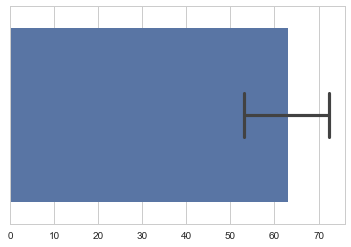

In [93]:
sns.barplot(x=["LSTM", "Simple RNN", "GRU"], data=df, capsize=.2)

So we can see that bost LSTM and GRU outperform the standard RNN. In average LSTM is slightly better than GRU but takes also more time to train.

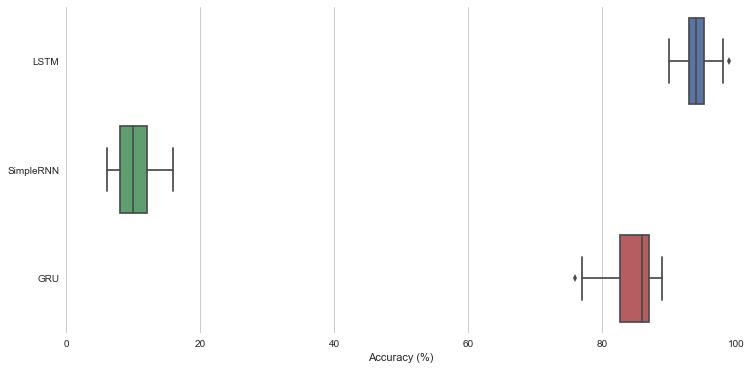

In [100]:
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(12, 6))

ax = sns.boxplot(x=[result_LSTM, result_SRNN, result_GRU], y=["LSTM", "SimpleRNN", "GRU"])
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 100), ylabel="",
       xlabel="Accuracy (%)")
sns.despine(left=True, bottom=True)
plt.savefig("boxplot.png")
plt.show()

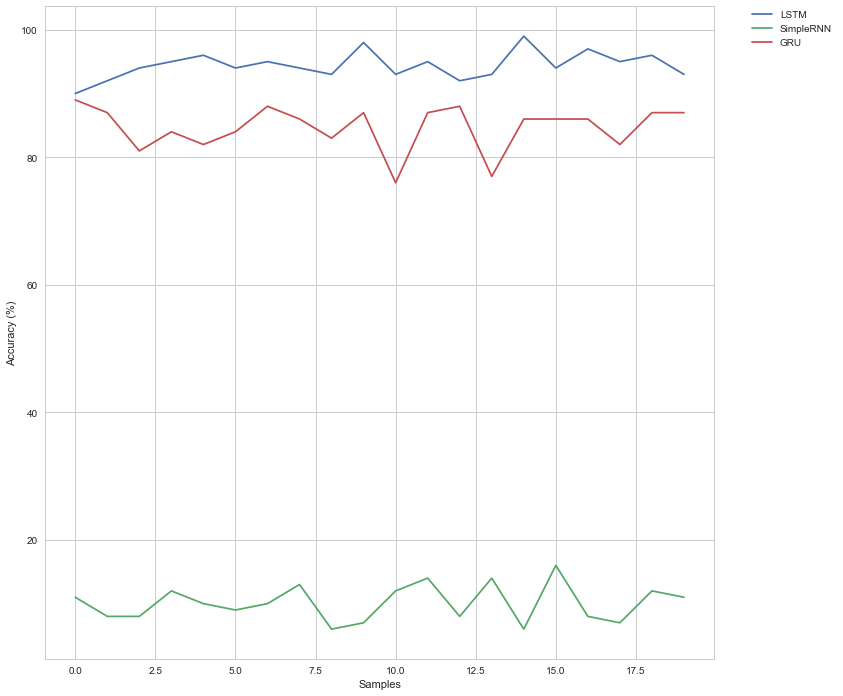

In [101]:
x = list(range(nb_samples))
y = [result_LSTM, result_SRNN, result_GRU]
labels = ["LSTM", "SimpleRNN", "GRU"]

plt.figure(figsize=(12, 12))
for y_arr, label in zip(y, labels):
    plt.plot(x, y_arr, label=label)

plt.xlabel("Samples")
plt.ylabel("Accuracy (%)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig("test_result.png")
plt.show()

## Conclusion

In this workbook, we started to go through RNN. We check a simple model of both LSTM, GRU and SimpleRNN to check how fast and well they learn. On this example GRU and LSTM outperform the standard RNN due to the memory function. There is also a difference between LSTM and GRU but with slightly more epochs, they both perform similar. We can probably have better result by using a more advanced model but for such a simple model, we can see that it works really well.

## Going further

On a future notebook, we will explore Embedded Reber but using deeper RNNs